In [4]:
import b3d
import jax.numpy as jnp
import os
from b3d import Mesh, Pose
import jax
import genjax
from genjax import Pytree
import rerun as rr
from b3d.modeling_utils import uniform_discrete, uniform_pose, gaussian_vmf
import matplotlib.pyplot as plt
from functools import partial

In [5]:
b3d.rr_init("interactive")
key = jax.random.PRNGKey(0)
ycb_dir = os.path.join(b3d.get_assets_path(), "bop/ycbv")
scene_id = 49
image_id = 100

all_data = b3d.io.get_ycbv_test_images(ycb_dir, scene_id, [image_id])

meshes = [
    Mesh.from_obj_file(os.path.join(ycb_dir, f'models/obj_{f"{id + 1}".rjust(6, "0")}.ply')).scale(0.001)
    for id in all_data[0]["object_types"]
]

height, width = all_data[0]["rgbd"].shape[:2]
fx,fy,cx,cy = all_data[0]["camera_intrinsics"]
scaling_factor = 0.3
renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor, height * scaling_factor, fx * scaling_factor, fy * scaling_factor, cx * scaling_factor, cy * scaling_factor, 0.01, 2.0
)

100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


2024-07-19 03:18:52.295393: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 4s:

  %reduce.868 = f32[10000,1]{1,0} reduce(f32[10000,1,480]{2,1,0} %broadcast.91, f32[] %constant.213), dimensions={2}, to_apply=%region_1.864, metadata={op_name="jit(image_from_parameters)/jit(main)/vmap(Categorical)/log_prob/reduce_max[axes=(2,)]" source_file="<@beartype(genjax._src.generative_functions.distributions.distribution.Distribution.simulate) at 0x7f8a23b6e160>" source_line=55}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-07-19 03:18:53.832612: E external/xla/xla/service/slow_operation_alarm.

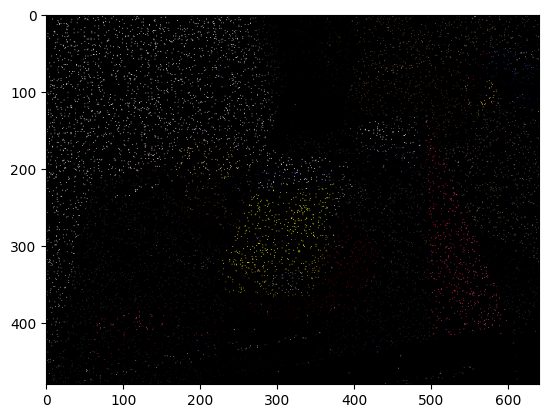

In [6]:
@genjax.gen
def ray_model(rendered_rgbd, k_array, likelihood_args):
    k = len(k_array)
    image_height, image_width = rendered_rgbd.shape[:2]

    row_coordinate = genjax.categorical.vmap(in_axes=(0,))(
            jnp.ones((k, image_height))
    )  @ "row_coordinate"
    column_coordinate = genjax.categorical.vmap(in_axes=(0,))(
            jnp.ones((k, image_width))
    ) @ "column_coordinate"


    color = rendered_rgbd[row_coordinate, column_coordinate, :3]
    depth = rendered_rgbd[row_coordinate, column_coordinate, 3]

    fx = likelihood_args["fx"]
    fy = likelihood_args["fy"]
    rendered_depth = rendered_rgbd[...,3]
    mesh_areas = (rendered_depth / fx) * (rendered_depth / fy)

    outlier_probability = genjax.uniform(0.0001, 0.9999) @ "outlier_probability"

    is_outlier = genjax.bernoulli.vmap(in_axes=(0,))(
        jnp.log(jnp.ones(k) * outlier_probability)) @ "is_outlier"

    outlier_color = genjax.uniform.vmap(in_axes=(0,0,))(jnp.ones((k,3)) * 0.0,  jnp.ones((k,3)) * 1.0) @ "outlier_color"
    outlier_depth = genjax.uniform.vmap(in_axes=(0,0,))(jnp.ones(k) * 0.0, jnp.ones(k) * 20.0) @ "outlier_depth"

    inlier_color_variance = genjax.uniform(0.01, 1.0) @ "inlier_color_variance"
    inlier_depth_variance = genjax.uniform(0.001, 1.0) @ "inlier_depth_variance"

    noisy_color = genjax.truncated_normal.vmap(in_axes=(0, 0, None, None))(
        color, jnp.ones((k,3)) * inlier_color_variance,
        0.0, 1.0
    ) @ "noisy_color"

    noisy_depth = genjax.truncated_normal.vmap(in_axes=(0, 0, None, None))(
        depth, jnp.ones(k) * inlier_depth_variance,
        0.0, 20.0
    ) @ "noisy_depth"

    outlier_rgbd_values = jnp.concatenate([outlier_color, outlier_depth[:,None]], axis=-1)
    inlier_rgbd_values = jnp.concatenate([noisy_color, noisy_depth[:,None]], axis=-1)
    values = jnp.where(is_outlier[...,None], outlier_rgbd_values, inlier_rgbd_values)

    observed_image = jnp.zeros((image_height, image_width, 4))
    observed_image = observed_image.at[row_coordinate, column_coordinate, :].set(values)
    return {"observed_image": observed_image}
    

likelikood_args = {
    "fx": fx * scaling_factor,
    "fy": fy * scaling_factor,
}


@partial(jax.jit, static_argnums=(1,))
def image_from_parameters(
    rendered_rgbd,
    k,
    outlier_probability,
    inllier_color_variance,
    inlier_depth_variance,
):
    choicemap = genjax.ChoiceMap.d(
        {
            "outlier_probability": outlier_probability,
            "inlier_color_variance": inllier_color_variance,
            "inlier_depth_variance": inlier_depth_variance,
        }
    )

    trace = ray_model.importance(
        key, 
        choicemap,
        (rendered_rgbd, jnp.arange(k), likelikood_args,),
    )[0]
    return trace
    
trace = image_from_parameters(all_data[0]["rgbd"], 10000, 0.01, 0.01, 0.01)
plt.imshow(trace.get_retval()["observed_image"][..., :3])

In [7]:
from ipywidgets import interact
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np

def plot(k,
    outlier_probability,
    inllier_color_variance,
    inlier_depth_variance):

    trace = image_from_parameters(all_data[0]["rgbd"], k,
    outlier_probability,
    inllier_color_variance,
    inlier_depth_variance)
    plt.imshow(trace.get_retval()["observed_image"][..., :3])
    print

interact(plot,
    k = widgets.IntSlider(value=75000, min=1, max=100000, step=1),
    outlier_probability = widgets.FloatSlider(value=0.01, min=0.01, max=1.0, step=0.01),
    inllier_color_variance = widgets.FloatSlider(value=0.01, min=0.01, max=1.0, step=0.01),
    inlier_depth_variance = widgets.FloatSlider(value=0.01, min=0.01, max=1.0, step=0.01),
)

interactive(children=(IntSlider(value=75000, description='k', max=100000, min=1), FloatSlider(value=0.01, desc…

<function __main__.plot(k, outlier_probability, inllier_color_variance, inlier_depth_variance)>

In [ ]:
from functools import partial

# @partial(jax.jit, static_argnums=(2,))
@jax.jit
def surface_krays_likelihood_intermediate(observed_rgbd, rendered_rgbd, likelihood_args):
    scaling_factor = likelihood_args["scaling_factor"].const
    fx = likelihood_args["fx"] * scaling_factor
    fy = likelihood_args["fy"] * scaling_factor


    observed_rgbd = b3d.utils.resize_image(
        observed_rgbd, observed_rgbd.shape[0], observed_rgbd.shape[1]
    )
    rendered_rgbd = b3d.utils.resize_image(
        rendered_rgbd, observed_rgbd.shape[0], observed_rgbd.shape[1]
    )

    observed_rgb = observed_rgbd[..., :3]
    observed_depth = observed_rgbd[...,3]

    rendered_rgb = rendered_rgbd[..., :3]
    rendered_depth = rendered_rgbd[...,3]

    observed_lab = b3d.colors.rgb_to_lab(observed_rgb) / jnp.array([100.0, 256.0, 256.0]) + jnp.array([0.0, 0.5, 0.5])
    rendered_lab = b3d.colors.rgb_to_lab(rendered_rgb) / jnp.array([100.0, 256.0, 256.0]) + jnp.array([0.0, 0.5, 0.5])

    color_variance = likelihood_args["color_variance"]
    depth_variance = likelihood_args["depth_variance"]
    outlier_probability = likelihood_args["outlier_probability"]
    outlier_volume = likelihood_args["outlier_volume"]

    multiplier = likelihood_args["multiplier"]

    observed_depth_corrected = observed_depth + (observed_depth == 0.0) * renderer.far
    rendered_areas = (rendered_depth / fx) * (rendered_depth / fy)
    observed_areas = (observed_depth_corrected / fx) * (observed_depth_corrected / fy)

    color_pdf = jax.scipy.stats.truncnorm.pdf(
        (observed_lab - rendered_lab),
        a=jnp.ones(3) * -1.0,
        b=jnp.ones(3) * 1.0,
        loc=jnp.zeros(3),
        scale=color_variance
    ).prod(-1)

    depth_width = 0.1
    depth_multiplier = 0.1
    depth_pdf = jax.scipy.stats.truncnorm.pdf(
        (observed_depth - rendered_depth) * depth_multiplier,
        a=-depth_width * depth_multiplier,
        b=depth_width * depth_multiplier,
        loc=0.0,
        scale=depth_variance
    )

    inliers_integral = color_pdf * depth_pdf * rendered_areas * (1.0 - outlier_probability)
    outlier_integral = observed_areas * 1 / outlier_volume * outlier_probability 
    pixelwise_score = (inliers_integral + outlier_integral)

    return {
        "score": jnp.log(jnp.sum(pixelwise_score))  * multiplier,
        "depth_score": depth_pdf,
        "color_score": color_pdf,
        "observed_rgbd": observed_rgbd,
        "latent_rgbd": rendered_rgbd,
        "outlier_integral": outlier_integral,
        "inliers_integral": inliers_integral,
        "pixelwise_score": pixelwise_score,
    }

import b3d.chisight.dense.dense_model
import importlib; importlib.reload(b3d.chisight.dense.dense_model)
dense_multiobject_model = b3d.chisight.dense.dense_model.make_dense_multiobject_model(
    renderer, surface_krays_likelihood_intermediate
)
importance_jit = jax.jit(dense_multiobject_model.importance)

In [ ]:
initial_camera_pose = all_data[0]["camera_pose"]
initial_object_poses = all_data[0]["object_poses"]
IDX = 0
pose = initial_camera_pose.inv() @ initial_object_poses[IDX]

batch_length = 1000
key = jax.random.split(key, 2)[-1]
w = 0.05
start_pose = pose @ Pose.sample_uniform_pose(
    key,
    -w/2*jnp.ones(3),
    w/2*jnp.ones(3)
)

test_poses = Pose.concatenate_poses(
    [
        pose @ Pose.sample_uniform_pose_vmap(
            jax.random.split(key, 20000),
            -w/2*jnp.ones(3),
            w/2*jnp.ones(3)
        ),
        # pose[None,...]
    ]
)
split_poses = [test_poses[i] for i in jnp.array_split(jnp.arange(test_poses.shape[0]), test_poses.shape[0] // batch_length + 1)]
# start_pose = pose
key = jax.random.split(jax.random.PRNGKey(0), 2)[-1]
likelihood_args= {
    "outlier_volume": 1.0,
    "multiplier": 40.0,
    "fx": fx,
    "fy": fy,
    "scaling_factor": Pytree.const(1.0),
}

def viz_trace(trace,t=0):
    rr.set_time_sequence("time", t)

    intermediate_info = surface_krays_likelihood_intermediate(
        trace.get_choices()["image"], 
        trace.get_retval()["latent_rgbd"],
        trace.get_retval()["likelihood_args"]
    )
    rr.log(
        f"img",
        rr.Image(intermediate_info["observed_rgbd"][...,:3])
    )
    rr.log(
        f"img/rerender",
        rr.Image(intermediate_info["latent_rgbd"][...,:3])
    )

In [ ]:
key = jax.random.split(key, 2)[-1]
w = 0.05

start_pose = pose @ Pose.sample_uniform_pose(
    key,
    -w/2*jnp.ones(3),
    w/2*jnp.ones(3)
)
choicemap = genjax.ChoiceMap.d(
    dict(
        [
            ("object_pose_0",  start_pose),
            ("image", 
                b3d.utils.resize_image(
                    all_data[0]["rgbd"], int(renderer.height * likelihood_args["scaling_factor"].const), int(renderer.width * likelihood_args["scaling_factor"].const)
                )
            )
        ]
    )
)


trace, _ = importance_jit(
    jax.random.PRNGKey(2),
    choicemap,
    ({"num_objects": Pytree.const(1), "meshes": [meshes[IDX]], "likelihood_args": likelihood_args},),
)
outlier_probability_sweep = jnp.linspace(0.001, 1.0, 100)
color_variance_sweep = jnp.linspace(0.1, 1.0, 100)
depth_variance_sweep = jnp.linspace(0.1, 1.0, 100)
current_color_variance = 0.2
current_depth_variance = 0.1
current_outlier_probability = 0.1
trace = b3d.update_choices(
    trace, key,
    Pytree.const(("outlier_probability", "color_variance", "depth_variance",)),
    current_outlier_probability, current_color_variance, current_depth_variance
)
viz_trace(trace)
print(trace.get_score())

In [ ]:
scores = b3d.enumerate_choices_get_scores(trace, key, Pytree.const(("outlier_probability",)), outlier_probability_sweep)
key = jax.random.split(key, 2)[-1]
current_outlier_probability = outlier_probability_sweep[jax.random.categorical(key, scores)]
print(f"Outlier probability: {current_outlier_probability}")
print(trace.get_score())

trace = b3d.update_choices(
    trace, key,
    Pytree.const(("outlier_probability", "color_variance", "depth_variance",)),
    current_outlier_probability, current_color_variance, current_depth_variance
)

scores = b3d.enumerate_choices_get_scores(trace, key, Pytree.const(("color_variance",)), color_variance_sweep)
key = jax.random.split(key, 2)[-1]
current_color_variance = color_variance_sweep[jax.random.categorical(key, scores)]
print(f"Color variance: {current_color_variance}")
print(trace.get_score())

trace = b3d.update_choices(
    trace, key,
    Pytree.const(("outlier_probability", "color_variance", "depth_variance",)),
    current_outlier_probability, current_color_variance, current_depth_variance
)

scores = b3d.enumerate_choices_get_scores(trace, key, Pytree.const(("depth_variance",)), depth_variance_sweep)
key = jax.random.split(key, 2)[-1]
current_depth_variance = depth_variance_sweep[jax.random.categorical(key, scores)]
print(f"Depth variance: {current_depth_variance}")
print(trace.get_score())

trace = b3d.update_choices(
    trace, key,
    Pytree.const(("outlier_probability", "color_variance", "depth_variance",)),
    current_outlier_probability, current_color_variance, current_depth_variance
)

test_poses = Pose.concatenate_poses([Pose.sample_gaussian_vmf_pose_vmap(
    jax.random.split(key, 5000),
    pose,
    0.1,
    200.0
)])
split_poses = [test_poses[i] for i in jnp.array_split(jnp.arange(test_poses.shape[0]), test_poses.shape[0] // batch_length + 1)]
scores = jnp.concatenate([
    b3d.enumerate_choices_get_scores(
        trace, key, Pytree.const(("object_pose_0",)), p
    )
    for p in split_poses
])
trace = b3d.update_choices(
    trace, key, Pytree.const(("object_pose_0",)), test_poses[jax.random.categorical(key, scores)]
)
viz_trace(trace)
print(trace.get_score())

In [ ]:
Outlier probability: 0.02118181809782982
59.66196
Color variance: 0.10000000149011612
58.84569
Depth variance: 0.15454545617103577
58.84569
61.315372

In [ ]:
b3d.normalize_log_scores(jnp.array([52.0 ,67.]))

In [ ]:
print(trace.get_choices()["color_variance"])
print(trace.get_retval()["likelihood_args"]["color_variance"])

print(trace.get_choices()["outlier_probability"])
print(trace.get_retval()["likelihood_args"]["outlier_probability"])

print(trace.get_choices()["depth_variance"])
print(trace.get_retval()["likelihood_args"]["depth_variance"])

In [ ]:
scores = b3d.enumerate_choices_get_scores(trace, key, Pytree.const("color_variance"), color_variance_sweep)
key = jax.random.split(key, 2)[-1]
color_variance_sweep[jax.random.categorical(key, scores)]
plt.plot(scores)
print(scores)

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np

outlier_probability_sweep = jnp.linspace(0.01, 1.0, 1000)

@jax.jit
def get_scores(color_variance, depth_variance):
    scores = jax.vmap(b3d.update_choices_get_score, in_axes=(None, None, None, 0, None, None))(
        trace, key, Pytree.const(("outlier_probability", "color_variance", "depth_variance",)),
        outlier_probability_sweep,
        color_variance, depth_variance
    )
    return scores

def plot(color_variance, depth_variance):
    plt.plot(outlier_probability_sweep, get_scores(color_variance, depth_variance))
    plt.ylim(-10.0, 0.0)

interact(plot,
    color_variance = widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.01),
    depth_variance = widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.01),
)

In [ ]:

batch_length = 1000
test_poses = Pose.concatenate_poses(
    [
        pose @ Pose.sample_uniform_pose_vmap(
            jax.random.split(key, 20000),
            -w/2*jnp.ones(3),
            w/2*jnp.ones(3)
        ),
        # pose[None,...]
    ]
)
split_poses = [test_poses[i] for i in jnp.array_split(jnp.arange(test_poses.shape[0]), test_poses.shape[0] // batch_length + 1)]
print(len(split_poses))

In [ ]:
@jax.jit
def fine_grain_inference(
    color_variance,
    depth_variance,
    outlier_prob,
    outlier_volume,
    multiplier,
    scaling_factor,
    test_poses,
    split_poses, 
):
    key = jax.random.split(jax.random.PRNGKey(0), 2)[-1]
    likelihood_args= {
        "color_variance": jnp.ones(3) * color_variance,
        "depth_variance": depth_variance,
        "outlier_prob": outlier_prob,
        "outlier_volume": outlier_volume,
        "multiplier": multiplier,
        "fx": fx,
        "fy": fy,
        "scaling_factor": scaling_factor
    }
    choicemap = genjax.ChoiceMap.d(
        dict(
            [
                ("object_pose_0",  pose),
                ("image", 
                    b3d.utils.resize_image(
                        all_data[0]["rgbd"], int(renderer.height * likelihood_args["scaling_factor"].const), int(renderer.width * likelihood_args["scaling_factor"].const)
                    )
                )
            ]
        )
    )
    trace, _ = importance_jit(
        jax.random.PRNGKey(2),
        choicemap,
        ({"num_objects": Pytree.const(1), "meshes": [meshes[IDX]], "likelihood_args": likelihood_args},),
    )
    scores = jnp.concatenate([
        b3d.enumerate_choices_get_scores(
            trace, key, Pytree.const(("object_pose_0",)), p
        )
        for p in split_poses
    ])

    sampled_indices = jax.random.categorical(key, scores, shape=(num_samples,))
    traces = b3d.enumerate_choices(
        trace, key, Pytree.const(("object_pose_0",)), test_poses[sampled_indices]
    )
    return traces

In [ ]:
def visualize_posterior_samples(
    color_variance,
    depth_variance,
    outlier_prob,
    outlier_volume,
    multiplier,
    scaling_factor,
    test_poses,
    split_poses,
):
    traces = fine_grain_inference(
        color_variance,
        depth_variance,
        outlier_prob,
        outlier_volume,
        multiplier,
        Pytree.const(scaling_factor),
        test_poses,
        split_poses,
    )

    intermediate_info = jax.vmap(surface_krays_likelihood_intermediate)(
        traces.get_choices()["image"], 
        traces.get_retval()["latent_rgbd"],
        traces.get_args()[0]["likelihood_args"]
    )

    for t in range(num_samples):
        rr.log(
            f"img_{t}",
            rr.Image(intermediate_info["observed_rgbd"][t][...,:3])
        )
        rr.log(
            f"img_{t}/rerender",
            rr.Image(intermediate_info["rendered_rgbd"][t][...,:3])
        )
    print("Done!")
    
    
visualize_posterior_samples(
    color_variance=0.01,
    depth_variance=0.02,
    outlier_prob=0.0001,
    outlier_volume=5.0,
    multiplier=65.0,
    scaling_factor=0.5,
    test_poses=test_poses,
    split_poses=split_poses
)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider
rr.set_time_sequence("time", 0)
cu = False
interact(
    visualize_posterior_samples,
    color_variance=FloatSlider(value=0.13,min=0.001, max=0.5, step=0.001, continuous_update=cu),
    depth_variance=FloatSlider(value=0.06,min=0.001, max=0.5, step=0.001, continuous_update=cu),
    outlier_prob=FloatSlider(value=0.001, min=0.00001, max=1.0, step=0.05, continuous_update=cu),
    outlier_volume=FloatSlider(value=1.0,min=1.0, max=10.0, step=1.0, continuous_update=cu),
    multiplier=FloatSlider(value=3.0,min=1.0, max=200.0, step=1.0, continuous_update=cu),
    scaling_factor=FloatSlider(value=0.5,min=0.2, max=1.0, step=0.1, continuous_update=cu),
    test_poses=fixed(test_poses),
    split_poses=fixed(split_poses)
)

In [ ]:
scores, scores.max()

In [ ]:
print(sampled_indices)
pose_samples = test_poses[sampled_indices]
images = renderer.render_rgbd_from_mesh(
    meshes[IDX].transform(pose_samples[0])
)
images = jax.vmap(
    lambda i: renderer.render_rgbd_from_mesh(
        meshes[IDX].transform(pose_samples[i])
    )
)(jnp.arange(len(pose_samples)))



for t in range(len(images)):
    rr.set_time_sequence("time", t)
    rr.log(
        "image/rerender",
        rr.Image(images[t][..., :3]),
    )


In [ ]:
scores.max()

In [ ]:
scores